In [1]:
import numpy as np
import pandas as pd
import cv2
import os 
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras 
from tensorflow.keras.models import  Model
from tensorflow.keras.layers import Conv2D ,MaxPooling2D ,UpSampling2D ,concatenate,Dropout ,Activation ,Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler ,ReduceLROnPlateau, EarlyStopping
from tensorflow.keras import backend as K

In [2]:
data=pd.read_csv('../input/chest-ct-segmentation/train.csv')

In [3]:
data.tail()

,ImageId,MaskId
16703,ID00426637202313170790466_403.jpg,ID00426637202313170790466_mask_403.jpg
16704,ID00426637202313170790466_404.jpg,ID00426637202313170790466_mask_404.jpg
16705,ID00426637202313170790466_405.jpg,ID00426637202313170790466_mask_405.jpg
16706,ID00426637202313170790466_406.jpg,ID00426637202313170790466_mask_406.jpg
16707,ID00426637202313170790466_407.jpg,ID00426637202313170790466_mask_407.jpg


In [4]:
data.columns

Index(['ImageId', 'MaskId'], dtype='object')

In [5]:
img=plt.imread('../input/chest-ct-segmentation/images/images/ID00007637202177411956430_0.jpg')
img.shape                    

(512, 512)

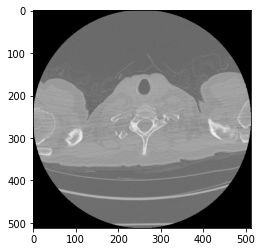

In [9]:
plt.imshow(img,cmap='gray')

In [10]:
mask=plt.imread('../input/chest-ct-segmentation/masks/masks/ID00007637202177411956430_mask_0.jpg')
mask.shape                    

(512, 512, 3)

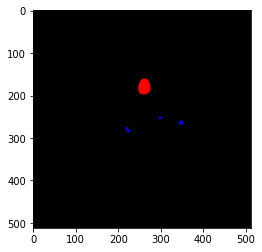

In [11]:
plt.imshow(mask)

In [12]:
mask

array([[[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       ...,

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]]], dtype=uint8)

In [32]:

from keras.preprocessing.image import ImageDataGenerator
# we create two instances with the same arguments

# VI Note: use the same seed for image_datagen and mask_datagen to ensure the transformation for image and mask is the same
data_gen_args = dict(rotation_range=0.2,
                    width_shift_range=0.05,
                    height_shift_range=0.05,
                    shear_range=0.05,
                    zoom_range=0.05,
                    horizontal_flip=True,
                    fill_mode='nearest',
                    rescale=1./255,
                    validation_split = 0.2)

mask_gen_args = dict(rotation_range=0.2,
                    width_shift_range=0.05,
                    height_shift_range=0.05,
                    shear_range=0.05,
                    zoom_range=0.05,
                    horizontal_flip=True,
                    fill_mode='nearest',
                    rescale=1./255,
                    validation_split = 0.2)
                    

image_datagen = ImageDataGenerator(**data_gen_args)
mask_datagen  = ImageDataGenerator(**mask_gen_args) 

In [43]:
# Provide the same seed and keyword arguments to the fit and flow methods
seed = 1

data_path='../input/chest-ct-segmentation/'
batch_sz=16
image_generator = image_datagen.flow_from_dataframe(
    dataframe=data,
    directory='../input/chest-ct-segmentation/images/images',
    class_mode=None,
    #classes=['images'],
    x_col='ImageId',
    seed=seed,
    color_mode='grayscale',
    batch_size=batch_sz,
    target_size=(256,256),
    subset='training'
)

Found 13367 validated image filenames.


In [44]:
# Provide the same seed and keyword arguments to the fit and flow methods
seed = 1

data_path='../input/chest-ct-segmentation/'
batch_sz=16
image_generator_val = image_datagen.flow_from_dataframe(
    dataframe=data,
    directory='../input/chest-ct-segmentation/images/images',
    class_mode=None,
    #classes=['images'],
    x_col='ImageId',
    seed=seed,
    color_mode='grayscale',
    batch_size=batch_sz,
    target_size=(256,256),
    subset='validation'
)

Found 3341 validated image filenames.


In [45]:
mask_generator = mask_datagen.flow_from_dataframe(
    dataframe=data,
    directory='../input/chest-ct-segmentation/masks/masks',
    #classes=['masks'],
    class_mode=None,
    x_col='MaskId',
    seed=seed,
    batch_size=batch_sz,
    color_mode='rgb',
    target_size=(256,256),
    subset='training')

Found 13367 validated image filenames.


In [46]:
mask_generator_val = mask_datagen.flow_from_dataframe(
    dataframe=data,
    directory='../input/chest-ct-segmentation/masks/masks',
    #classes=['masks'],
    class_mode=None,
    x_col='MaskId',
    seed=seed,
    batch_size=batch_sz,
    color_mode='rgb',
    target_size=(256,256),
    subset='validation')

Found 3341 validated image filenames.


In [47]:
# combine generators into one which yields image and masks
train_generator = zip(image_generator, mask_generator)
def train_generator_fn():
    for (img,mask) in train_generator:
        yield (img,mask)        

In [48]:
# combine generators into one which yields image and masks
valid_generator = zip(image_generator_val, mask_generator_val)
def valid_generator_fn():
    for (img,mask) in valid_generator:
        yield (img,mask)        

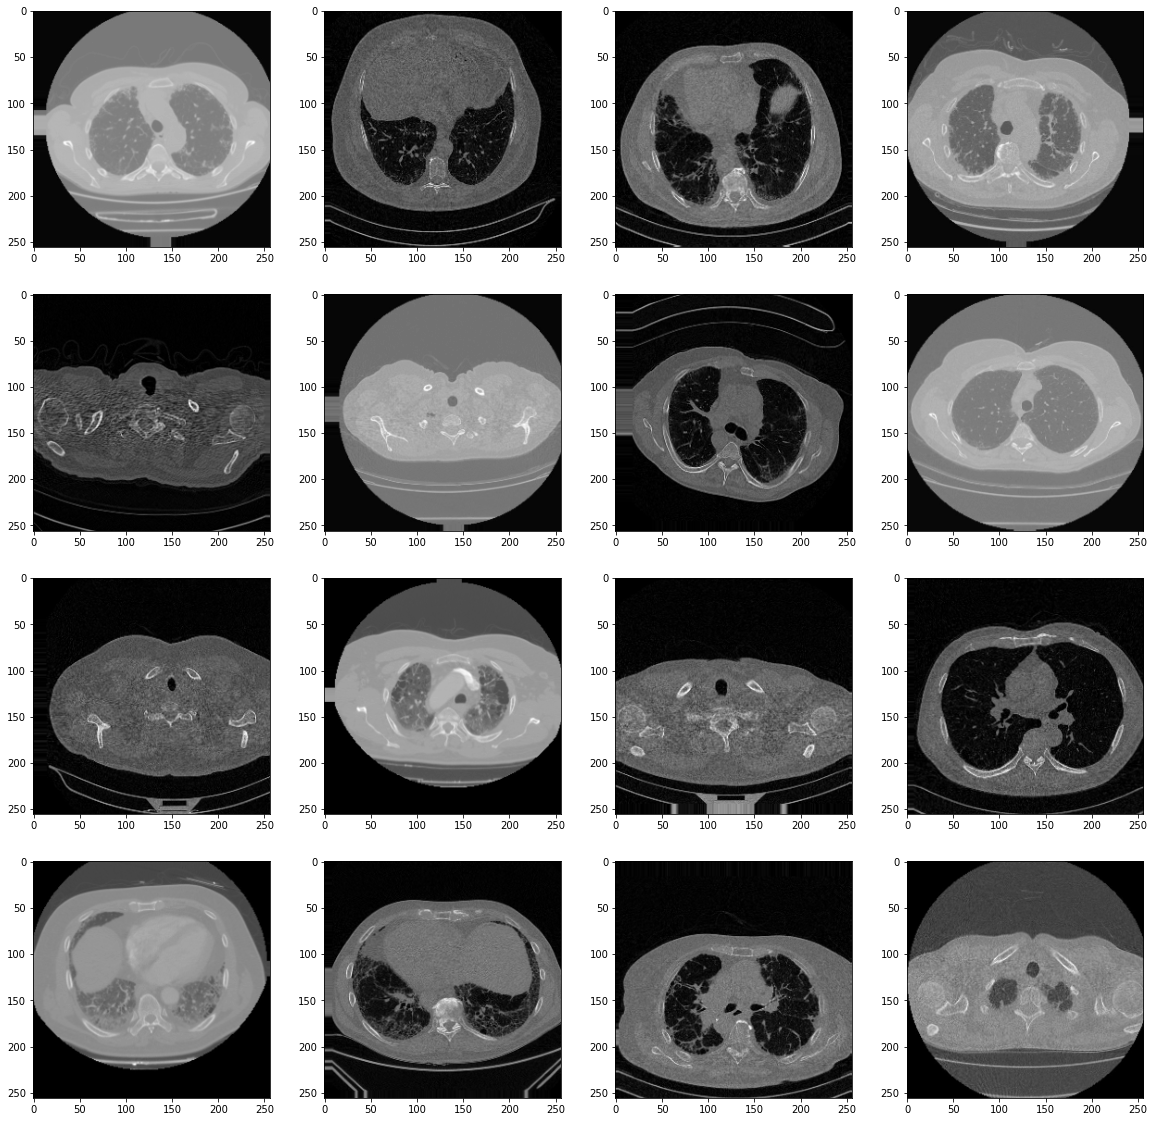

In [20]:
plt.figure(figsize=(20,20))
for X_batch, y_batch in train_generator:
    # create a grid of 3x3 images
    for i in range(0,16):
        plt.subplot(4,4,i+1)
        plt.imshow(X_batch[i],cmap='gray')
    # show the plot
    plt.show()
    break

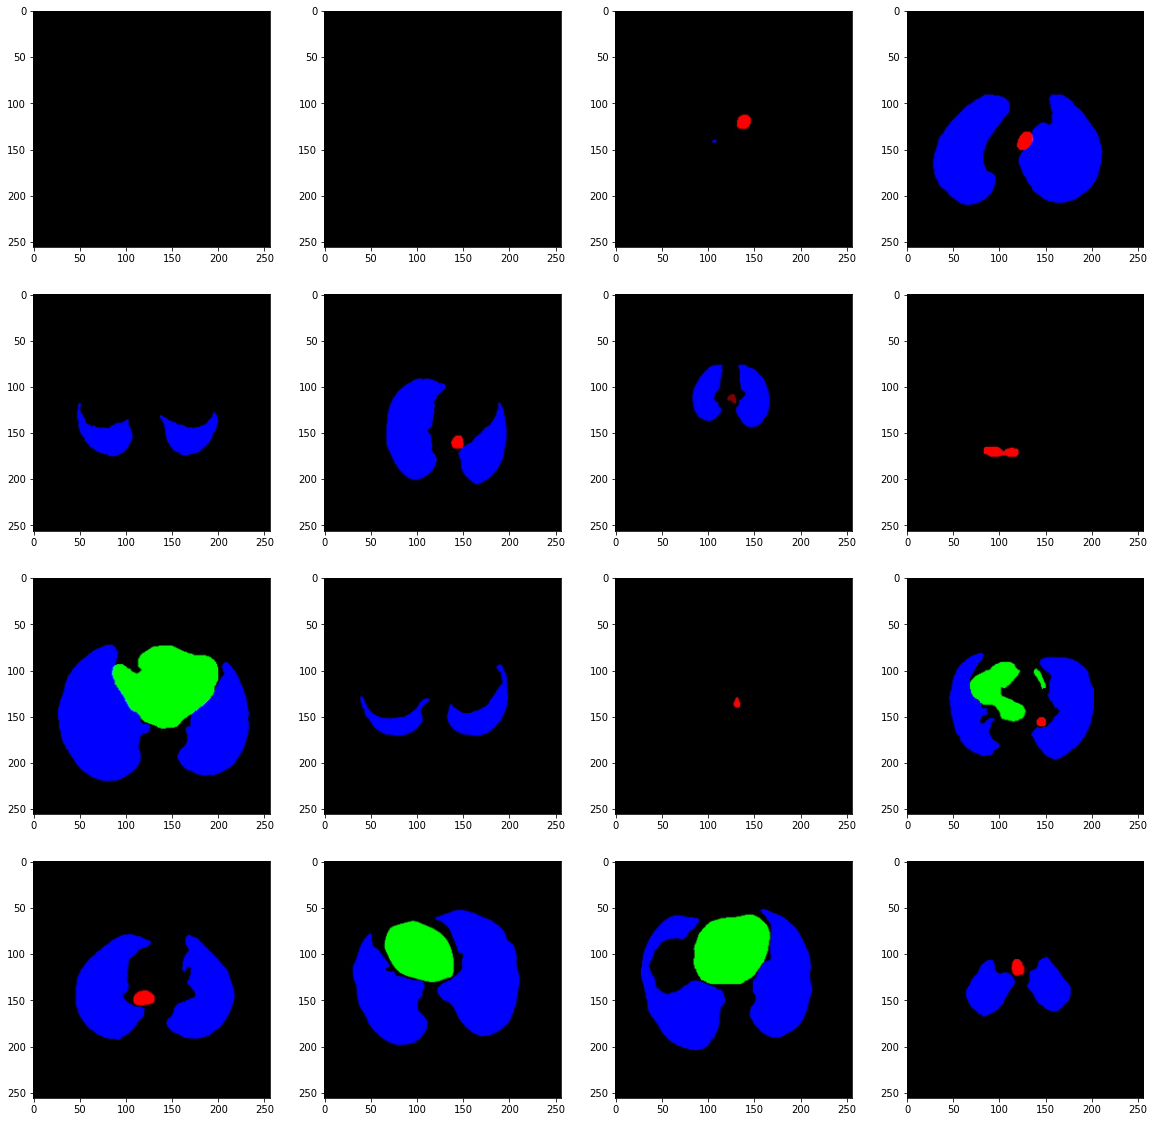

In [21]:
plt.figure(figsize=(20,20))
for X_batch, y_batch in train_generator:
    # create a grid of 3x3 images
    for i in range(0,16):
        plt.subplot(4,4,i+1)
        plt.imshow(y_batch[i])
    # show the plot
    plt.show()
    break

In [90]:
def unet(n_classes,input_size = (256,256,1)):
    inputs = Input(input_size)
    conv1 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(inputs)
    conv1 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool1)
    conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool2)
    conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    conv4 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool3)
    conv4 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv4)
    drop4 = Dropout(0.5)(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)

    conv5 = Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool4)
    conv5 = Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv5)
    drop5 = Dropout(0.5)(conv5)

    x = UpSampling2D(size = (2,2))(drop5)
    up6 = Conv2D(512, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(x)
    merge6 = concatenate([drop4,up6], axis = 3)
    conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge6)
    conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv6)

    up7 = Conv2D(256, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv6))
    merge7 = concatenate([conv3,up7], axis = 3)
    conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge7)
    conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv7)

    up8 = Conv2D(128, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv7))
    merge8 = concatenate([conv2,up8], axis = 3)
    conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge8)
    conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv8)

    up9 = Conv2D(64, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv8))
    merge9 = concatenate([conv1,up9], axis = 3)
    conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge9)
    conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
    
    conv10 = Conv2D(n_classes, (1,1), padding='same')(conv9)
    
    output_layer = Activation('softmax')(conv10)
     

    model = Model(inputs = inputs, outputs = output_layer)

    return model

In [91]:
model = unet(n_classes=3)
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 256, 256, 1) 0                                            
__________________________________________________________________________________________________
conv2d_23 (Conv2D)              (None, 256, 256, 64) 640         input_2[0][0]                    
__________________________________________________________________________________________________
conv2d_24 (Conv2D)              (None, 256, 256, 64) 36928       conv2d_23[0][0]                  
__________________________________________________________________________________________________
max_pooling2d_4 (MaxPooling2D)  (None, 128, 128, 64) 0           conv2d_24[0][0]                  
____________________________________________________________________________________________

In [92]:
smooth=1.

def dice_coef(y_true, y_pred):
    y_true = K.flatten(y_true)
    y_pred = K.flatten(y_pred)
    intersection = K.sum(y_true * y_pred)
    union = K.sum(y_true) + K.sum(y_pred)
    return (2.0 * intersection + smooth) / (union + smooth)

def dice_coef_loss(y_true, y_pred):
    return 1 - dice_coef(y_true, y_pred)

def bce_dice_loss(y_true, y_pred):
    bce = tf.keras.losses.BinaryCrossentropy(from_logits=True)
    return dice_coef_loss(y_true, y_pred) + bce(y_true, y_pred)

def iou(y_true, y_pred):
    intersection = K.sum(y_true * y_pred)
    sum_ = K.sum(y_true + y_pred)
    jac = (intersection + smooth) / (sum_ - intersection + smooth)
    return jac

In [108]:
EarlyStop=EarlyStopping(patience=10,restore_best_weights=True)
Reduce_LR=ReduceLROnPlateau(monitor='val_loss',verbose=2,factor=0.5,min_lr=0.00001)
model_checkpoint = ModelCheckpoint('unet_camvid.hdf5', monitor='val_loss',verbose=1, save_best_only=True)
callback=[EarlyStop , Reduce_LR,model_checkpoint]

In [94]:
model.compile(optimizer=Adam(learning_rate = 1e-4), loss=bce_dice_loss, metrics=[iou, dice_coef])

In [95]:

model.fit(train_generator_fn(),
                    validation_data=valid_generator_fn(),
                    steps_per_epoch=1000,
                    validation_steps=10,
                    epochs=20,
                    callbacks=callback)

Epoch 1/20
100/100 [==============================] - 106s 655ms/step - loss: 0.9432 - iou: 0.0940 - dice_coef: 0.1712 - val_loss: 1.0092 - val_iou: 0.0495 - val_dice_coef: 0.0941

Epoch 00001: val_loss improved from inf to 1.00921, saving model to unet_camvid.hdf5
Epoch 2/20
100/100 [==============================] - 65s 652ms/step - loss: 0.8798 - iou: 0.1044 - dice_coef: 0.1885 - val_loss: 0.9328 - val_iou: 0.0705 - val_dice_coef: 0.1310

Epoch 00002: val_loss improved from 1.00921 to 0.93279, saving model to unet_camvid.hdf5
Epoch 3/20
100/100 [==============================] - 65s 653ms/step - loss: 0.8605 - iou: 0.1070 - dice_coef: 0.1927 - val_loss: 0.9557 - val_iou: 0.0540 - val_dice_coef: 0.1020

Epoch 00003: val_loss did not improve from 0.93279
Epoch 4/20
100/100 [==============================] - 65s 649ms/step - loss: 0.8605 - iou: 0.1065 - dice_coef: 0.1918 - val_loss: 0.9189 - val_iou: 0.0704 - val_dice_coef: 0.1308

Epoch 00004: val_loss improved from 0.93279 to 0.91892

Text(0.5, 1.0, 'Dice Coef')

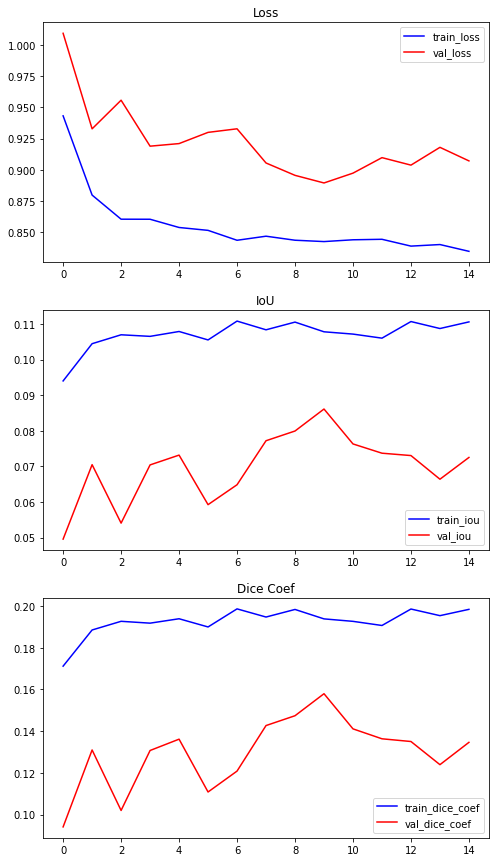

In [96]:
plt.figure(figsize=(8,15))
plt.subplot(3,1,1)
plt.plot(model.history.history['loss'], 'b-', label='train_loss')
plt.plot(model.history.history['val_loss'], 'r-', label='val_loss')
plt.legend(loc='best')
plt.title('Loss')

plt.subplot(3,1,2)
plt.plot(model.history.history['iou'], 'b-', label='train_iou')
plt.plot(model.history.history['val_iou'], 'r-', label='val_iou')
plt.legend(loc='best')
plt.title('IoU')

plt.subplot(3,1,3)
plt.plot(model.history.history['dice_coef'], 'b-', label='train_dice_coef')
plt.plot(model.history.history['val_dice_coef'], 'r-', label='val_dice_coef')
plt.legend(loc='best')
plt.title('Dice Coef')

In [118]:
test=plt.imread('../input/chest-ct-segmentation/images/images/ID00007637202177411956430_11.jpg')

In [119]:
test.shape

(512, 512)

In [120]:
test=cv2.resize(test,(256,256))
test=test/255.0

In [121]:
test.shape

(256, 256)

In [122]:
test=np.expand_dims(test,axis=0)

In [123]:
pred=model.predict(test)

In [124]:
pred.shape

(1, 256, 256, 3)

In [125]:
pred=pred.reshape(256,256,3)

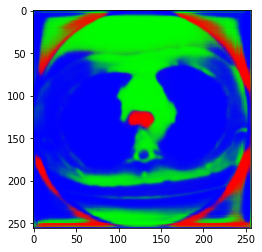

In [126]:
plt.imshow(pred)

In [127]:
mask=plt.imread('../input/chest-ct-segmentation/masks/masks/ID00007637202177411956430_mask_11.jpg')

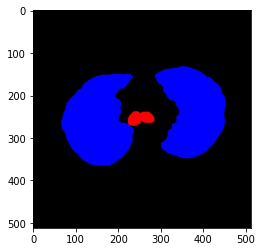

In [128]:
plt.imshow(mask)